## Identifying Aggregations of Waste
### Atividade Final CAP-354 Inteligência Artificial
Prof. Dr. Elcio Hideiti Shiguemori and Prof. Dr. Lamartine Nogueira Frutuoso Guimarães 
<br>
Júlia Ascencio Cansado - 511871/2025

Notebook focused on the label model for combining different source / method data creation

In [1]:
# !pip install earthengine-api
# !pip install folium
# !pip install pandas
# !pip install tensorflow 

import ee
import pandas as pd
import numpy as np
import folium
from folium.utilities import image_to_url
import os
import zipfile
import rasterio
from rasterio.windows import Window

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU

2025-06-13 14:34:11.353853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749825251.366009  584651 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749825251.369693  584651 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749825251.380658  584651 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749825251.380671  584651 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749825251.380672  584651 computation_placer.cc:177] computation placer alr

In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Previous steps

Before running this notebook, I ran a [Google Earth Engine script](https://code.earthengine.google.com/8df4a25d5db8b07ffeee622498212e62) to create weak supervision samples - both supervised (using Random Forest) and unsupervised (using Kmeans).
<br>
The results of that script are used below, accessed through earthengine-api.

In [4]:
# Authenticate and initialize Earth Engine
try:
    ee.Initialize(project='dumpsites-id')
except ee.EEException as e:
    ee.Authenticate()
    ee.Initialize(project='dumpsites-id')


In [400]:
# Parameters
PATCH_SIZE = 128  
SCALE = 10  
STRIDE = 64 
BANDS = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI', 'WasteIndex']
# SUPERVISED = ['final_supervised_label']
SUPERVISED = ['kmeans_validated_label']  
PATCHES_PER_GEOM = 100  
MAX_TRIES = 3            
KERNEL_SIZE  = 128
BATCH_SIZE = 16 
BUFFER_SIZE = 100 
EPOCHS = 20 
NUM_BANDS = len(BANDS)

MOSAIC_VERSION = '4'
SAMPLE_VERSION = '5'

# Define training polygons - this is also in the Earth Engine script
trainingPolys = ee.FeatureCollection('projects/dumpsites-id/assets/export_geoms_train_v1')
validationPolys = ee.FeatureCollection('projects/dumpsites-id/assets/export_geoms_val_v1')
testingPolys = ee.FeatureCollection('projects/dumpsites-id/assets/export_geoms_test_v1')


composite = ee.Image('projects/dumpsites-id/assets/pws_waste_detection_label_v6').select(BANDS)
labels = ee.Image('projects/dumpsites-id/assets/pws_waste_detection_label_v6').select(SUPERVISED)

labeled_image = composite.addBands(labels)

geometries_train = trainingPolys.geometry().getInfo()
geometries_val = validationPolys.geometry().getInfo()
geometries_test = testingPolys.geometry().getInfo()


### Preparing geometries for exporting training patches
The outputs of the previously mentioned Google Earth Engine script are ee.FeatureCollections, which we need to transform into a list of ee.Geometry(ies) to iterate over (extracting patches from each one).
Remember that after extraction you'll have to upload them into your environment for training/validation

In [298]:
def multipoly2polylist(multipoly):
    size = len(multipoly.get('coordinates'))
    print(size)
    polylist = ee.List.sequence(0, ee.Number(size).subtract(1))
    newList = []
    # print(polylist.getInfo())
    for i in polylist.getInfo():
        coords = ee.Geometry.Polygon(multipoly.get('coordinates')[i])
        newList.append(coords)
    return newList
    
separate_geoms_train = multipoly2polylist(geometries_train)
separate_geoms_val = multipoly2polylist(geometries_val)
separate_geoms_test = multipoly2polylist(geometries_test)

5
1
1


In [299]:
# Test geometries
print(separate_geoms_val)

[ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -46.5893031492091,
              -23.450167167105985
            ],
            [
              -46.54559952190209,
              -23.450167162383654
            ],
            [
              -46.5018958573013,
              -23.450167212934264
            ],
            [
              -46.5018958573013,
              -23.384065497627702
            ],
            [
              -46.54559952190209,
              -23.384065512205307
            ],
            [
              -46.5893031492091,
              -23.384065498353895
            ],
            [
              -46.5893031492091,
              -23.450167167105985
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})]


In [300]:
# Join Sentinel imagery and label
featureStack = ee.Image.cat([
  composite.select(BANDS).unmask(0),
  labels.select(SUPERVISED).unmask(0)
]).float()

list = ee.List.repeat(1, KERNEL_SIZE)
lists = ee.List.repeat(list, KERNEL_SIZE)
kernel = ee.Kernel.fixed(KERNEL_SIZE, KERNEL_SIZE, lists)

arrays = featureStack.neighborhoodToArray(kernel)

In [301]:
# Visualize training data
label_vis_params = {
    'min': 0,
    'max': 1,
    'palette': ['black', 'red'] 
}

map_center = ee.Geometry.MultiPolygon(separate_geoms_train).centroid().coordinates().getInfo()[::-1] 
zoom_level = 11 

m = folium.Map(location=map_center, zoom_start=zoom_level)

tile_url = labels.select(SUPERVISED).getMapId(label_vis_params)['tile_fetcher'].url_format
folium.TileLayer(
    tiles=tile_url,
    attr='Earth Engine Labels',
    overlay=True,
    name='Supervised Labels'
).add_to(m)

folium.GeoJson(
    trainingPolys.getInfo(),
    name='Training Geometries',
    style_function=lambda x: {
        'fillColor': 'blue', 
        'color': 'blue',          #
        'weight': 2,
        'fillOpacity': 0.6
    }
).add_to(m)

folium.GeoJson(
    validationPolys.getInfo(),
    name='Validation Geometries',
    style_function=lambda x: {
        'fillColor': 'green', 
        'color': 'green',          #
        'weight': 2,
        'fillOpacity': 0.6
    }
).add_to(m)

folium.GeoJson(
    testingPolys.getInfo(),
    name='Testing Geometries',
    style_function=lambda x: {
        'fillColor': 'red', 
        'color': 'red',          #
        'weight': 2,
        'fillOpacity': 0.6
    }
).add_to(m)

folium.LayerControl().add_to(m)

m

In [397]:
n = 20 
N = 200 

# Export one type oof data at a time
polyList = trainingPolys
# polyList = validationPolys
polyList = testingPolys 

if polyList == trainingPolys:        # original ee.FeatureCollection
    base = 'training_patches'       # name base
    geoms = separate_geoms_train     # list of ee.Geometries
elif polyList == validationPolys:
    base = 'validation_patches'
    geoms = separate_geoms_val
elif polyList == testingPolys:
    base = 'testing_patches'
    geoms = separate_geoms_test
else:
    print('something is wrong')

# print(base)
# print(geoms)

BASE  = base+'_'+SUPERVISED[0]+'_'+MOSAIC_VERSION+'_v'+SAMPLE_VERSION
GDRIVE = 'dumpsites_id'
FOLDER = f'{base}_v{SAMPLE_VERSION}'

SIZE = len(geoms)*N
print(f'{base}: {(SIZE)}')

# Export all the training data 
for g in range(polyList.size().getInfo()):
  geomSample = ee.FeatureCollection([])
  for i in range(n):
    sample = arrays.sample(
      region = ee.Feature(sep_geoms[g]).geometry(), 
      scale = 10, 
      numPixels = N / n, # Size of the shard.
      seed = i,
      tileScale = 8
    )
    geomSample = geomSample.merge(sample)
  
  desc = BASE+ '_g' + str(g)

  task = ee.batch.Export.table.toDrive(
   collection = geomSample,
   description = desc, 
   folder = GDRIVE+'/'+FOLDER, 
   fileNamePrefix = desc,
   fileFormat = 'TFRecord',
   selectors = BANDS + [SUPERVISED]
  )
  # task.start() --> uncomment to start exporting tasks in EE

testing_patches: 200


## Getting and preparing input data
Before training, I have to get and prepare the exported samples (here they can be the one generated with Random Forest or KMeans)

In [304]:
def parse_tfrecord_function(example_proto):
    feature_description = {
        band: tf.io.FixedLenFeature(shape=[PATCH_SIZE, PATCH_SIZE], dtype=tf.float32) 
        for band in BANDS
    }
    feature_description[SUPERVISED[0]] = tf.io.FixedLenFeature(
        shape=[PATCH_SIZE, PATCH_SIZE], dtype=tf.float32 # Or tf.int32 if labels are integer
    )

    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    image_bands = [parsed_features[band] for band in BANDS]
    image = tf.stack(image_bands, axis=-1)
    

    label = tf.expand_dims(parsed_features[SUPERVISED[0]], axis=-1)

    # Normalize image 
    image = image / 10000.0 

    return image, label

def create_dataset(tfrecord_paths, batch_size, buffer_size, shuffle=True):
    dataset = tf.data.TFRecordDataset(tfrecord_paths)
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.map(parse_tfrecord_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size) # Or tf.data.AUTOTUNE
    return dataset


In [403]:
# WHICH LABEL AM I USING NOW?
print(SUPERVISED[0])

kmeans_validated_label


In [404]:
import os
print(os.getcwd())
print(base) #chaeck base

/mnt/nfs/assets/dumpsites/notebooks
testing_patches


In [401]:
tfrecord_dir = '/mnt/nfs/assets/dumpsites/data/' + SUPERVISED[0] + '_v' + SAMPLE_VERSION

tfrecord_files = [os.path.join(tfrecord_dir, f) for f in os.listdir(tfrecord_dir) if f.endswith('.tfrecord.gz')]
# print(tfrecord_files)

print(f"Found {len(tfrecord_files)} TFRecord files.")
print(f"Example file: {tfrecord_files[0]}")

# # Create the training dataset
train_dataset = create_dataset(tfrecord_files, BATCH_SIZE, BUFFER_SIZE)
print(train_dataset)

Found 6 TFRecord files.
Example file: /mnt/nfs/assets/dumpsites/data/kmeans_validated_label_v5/training_patches_kmeans_validated_label_1_v5_g4.tfrecord.gz
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


In [402]:
def parse_tfrecord_example(example_proto):
    """
    Parses a single tf.train.Example proto using the predefined FEATURES_DICT.
    Args:
        example_proto: A serialized Example.
    Returns:
        A dictionary of tensors, keyed by feature name.
    """
    return tf.io.parse_single_example(example_proto, FEATURES_DICT)

def stack_and_split(parsed_features):

    tensors_list = [parsed_features.get(key) for key in FEATURES_ORDER]
    
    stacked_chw = tf.stack(tensors_list, axis=0)
    
    stacked_hwc = tf.transpose(stacked_chw, [1, 2, 0])

    image = stacked_hwc[:, :, :NUM_BANDS]
    label = stacked_hwc[:, :, NUM_BANDS:] # This will be [PATCH_SIZE, PATCH_SIZE, NUM_CLASSES]


    image = image / 10000.0


    return image, label

def get_dataset(pattern, compression_type='GZIP'):

    glob_paths = tf.io.gfile.glob(pattern)
    if not glob_paths:
        raise FileNotFoundError(f"No files found matching pattern: {pattern}")
    
    dataset = tf.data.Dataset.from_tensor_slices(glob_paths)
    
    dataset = dataset.shuffle(len(glob_paths))

    dataset = dataset.interleave(
        lambda filepath: tf.data.TFRecordDataset(filepath, compression_type=compression_type),
        cycle_length=tf.data.AUTOTUNE, # Read from multiple files concurrently
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.map(parse_tfrecord_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(stack_and_split, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset

def get_base_dataset(base_type='training_patches'):
 
    glob_pattern = tfrecord_dir + '/' + base_type + '*tfrecord.gz'

    dataset = get_dataset(glob_pattern, compression_type='GZIP') # Ensure GZIP if your files are .gz

    dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat() # Repeat indefinitely for training loop
    dataset = dataset.prefetch(tf.data.AUTOTUNE) # Prefetch for performance
    return dataset

def get_preview_dataset(num_batches=3, base_type='training_patches'):
    glob_pattern = tfrecord_dir + '/' + base_type + '*tfrecord.gz'
    dataset = get_dataset(glob_pattern, compression_type='GZIP')
    dataset = dataset.shuffle(BUFFER_SIZE) # Shuffle for diverse samples
    dataset = dataset.batch(1) # Process one image at a time for visualization
    return dataset.take(num_batches) # Take only a few batches for preview

In [308]:
FEATURES_DICT = {
    band: tf.io.FixedLenFeature(shape=[PATCH_SIZE, PATCH_SIZE], dtype=tf.float32)
    for band in BANDS
}
FEATURES_DICT[SUPERVISED[0]] = tf.io.FixedLenFeature(
    shape=[PATCH_SIZE, PATCH_SIZE], dtype=tf.float32 # Use tf.int32 if your labels are strictly integers and not floats
)

FEATURES_ORDER = BANDS + [SUPERVISED[0]]

print(f"Looking for TFRecord files in: {tfrecord_dir}")
training_dataset = get_base_dataset()
validation_dataset = get_base_dataset(base_type='validation_patches')

print("\nVerifying training dataset structure...")
try:
    for image_batch, label_batch in training_dataset.take(1):
        print(f"Batch Image Shape: {image_batch.shape}")    # Expected: (BATCH_SIZE, PATCH_SIZE, PATCH_SIZE, NUM_BANDS)
        print(f"Batch Label Shape: {label_batch.shape}")    # Expected: (BATCH_SIZE, PATCH_SIZE, PATCH_SIZE, NUM_CLASSES)
        print(f"Image Dtype: {image_batch.dtype}")
        print(f"Label Dtype: {label_batch.dtype}")
        print("Dataset structure verified successfully.")
except Exception as e:
    print(f"Error verifying dataset structure: {e}")
    print("Please check your TFRecord files and parsing logic.")
    exit()


print("\nVerifying validation dataset structure...")
try:
    for image_batch, label_batch in validation_dataset.take(1):
        print(f"Batch Image Shape: {image_batch.shape}")    # Expected: (BATCH_SIZE, PATCH_SIZE, PATCH_SIZE, NUM_BANDS)
        print(f"Batch Label Shape: {label_batch.shape}")    # Expected: (BATCH_SIZE, PATCH_SIZE, PATCH_SIZE, NUM_CLASSES)
        print(f"Image Dtype: {image_batch.dtype}")
        print(f"Label Dtype: {label_batch.dtype}")
        print("Dataset structure verified successfully.")
except Exception as e:
    print(f"Error verifying dataset structure: {e}")
    print("Please check your TFRecord files and parsing logic.")
    exit()


Looking for TFRecord files in: /mnt/nfs/assets/dumpsites/data/kmeans_validated_label_v5

Verifying training dataset structure...
Batch Image Shape: (16, 128, 128, 10)
Batch Label Shape: (16, 128, 128, 1)
Image Dtype: <dtype: 'float32'>
Label Dtype: <dtype: 'float32'>
Dataset structure verified successfully.

Verifying validation dataset structure...
Batch Image Shape: (16, 128, 128, 10)
Batch Label Shape: (16, 128, 128, 1)
Image Dtype: <dtype: 'float32'>
Label Dtype: <dtype: 'float32'>
Dataset structure verified successfully.


### Defining model and training
Here I am using a U-Net based architecture

In [303]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape, num_classes, num_bands):
    inputs = layers.Input(input_shape)

    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = layers.Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    up6 = layers.concatenate([up6, drop4])
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv3])
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    up8 = layers.concatenate([up8, conv2])
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    up9 = layers.concatenate([up9, conv1])
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)


    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(conv9)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [309]:
NUM_CLASSES = 1
input_shape = (PATCH_SIZE, PATCH_SIZE, NUM_BANDS)
model = unet_model(input_shape, NUM_CLASSES, NUM_BANDS)

# Choose loss function and metrics
# For binary segmentation, BinaryCrossentropy is common.
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False)

metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.MeanIoU(num_classes=2, name='mean_iou') # For binary classification (0 or 1)
]

model.compile(optimizer='adam', loss=loss_fn, metrics=metrics)

# summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 128, 128,  │      5,824 │ input_layer_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_57[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_58[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_59[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ conv2d_60[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_13… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_61[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 16, 16,    │          0 │ conv2d_62[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_14… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_63[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_64[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 8, 8, 512) │          0 │ dropout_6[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_15… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_65[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 8, 8,      │          0 │ conv2d_66[0][0] 

 Total params: 31,035,777 (118.39 MB)

 Trainable params: 31,035,777 (118.39 MB)

 Non-trainable params: 0 (0.00 B)

In [310]:
# Function for looking at the input, label and prediction of the model
import matplotlib.pyplot as plt

class ImagePredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self, preview_dataset, frequency=5, rgb_band_indices=[2, 1, 0]):
        super().__init__()
        self.preview_dataset = preview_dataset
        self.frequency = frequency
        self.rgb_band_indices = rgb_band_indices

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.frequency == 0: # +1 because epoch is 0-indexed
            print(f"\n--- Previewing predictions at Epoch {epoch + 1} ---")
            counter = 0
            for i, (pure_image, supervised_label) in enumerate(self.preview_dataset):
                if counter >= 3: # Limit to 3 previews per epoch
                    break
                test_pred_raw = self.model.predict(pure_image) # Use self.model
                
                # Plotting
                fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # Adjusted figsize for better viewing

                rgb_display = tf.gather(pure_image[0], tf.constant(self.rgb_band_indices), axis=-1)
                rgb_display = tf.clip_by_value(rgb_display, 0.0, 1.0) * 255
                axes[0].imshow(rgb_display.numpy().astype(np.uint8))

                band_names = [BANDS[idx] for idx in self.rgb_band_indices]
                axes[0].set_title('Original Image (B8,B4,B3)')
                axes[0].axis('off')

                axes[1].imshow(supervised_label[0, :, :, 0].numpy(), cmap="gray", vmin=0, vmax=1)
                axes[1].set_title('Ground Truth Label')
                axes[1].axis('off')

                predicted_mask = (test_pred_raw[0, :, :, 0] > 0.5).astype(np.float32) # Threshold at 0.5 for binary
                axes[2].imshow(predicted_mask, cmap="gray", vmin=0, vmax=1)
                axes[2].set_title(f'Model Prediction (Epoch {epoch + 1})')
                axes[2].axis('off')

                plt.tight_layout()
                plt.show()
                counter += 1

In [311]:
def get_counting_dataset(base_type='training_patches'):
    glob_pattern = tfrecord_dir + '/' + base_type + '*tfrecord.gz'
    dataset = get_dataset(glob_pattern, compression_type='GZIP')
    # No batching, no repeating, no shuffling for counting
    return dataset



In [312]:
print("\nCounting total records in the training dataset...")
counting_dataset = get_counting_dataset()
TRAIN_SIZE = 0
for _ in counting_dataset:
    TRAIN_SIZE += 1
print(f"Total training records (TRAIN_SIZE): {TRAIN_SIZE}")

if TRAIN_SIZE == 0:
    raise ValueError("TRAIN_SIZE is 0. No training data found or parsed correctly.")

print("\nCounting total records in the validation dataset...")
counting_dataset = get_counting_dataset(base_type='validation_patches')
EVAL_SIZE = 0
for _ in counting_dataset:
    EVAL_SIZE += 1
print(f"Total validation records (EVAL_SIZE): {EVAL_SIZE}")

if EVAL_SIZE == 0:
    raise ValueError("TRAIN_SIZE is 0. No training data found or parsed correctly.")


Counting total records in the training dataset...
Total training records (TRAIN_SIZE): 1000

Counting total records in the validation dataset...
Total validation records (EVAL_SIZE): 200


In [313]:
SUPERVISED[0] # Confirm label used

'kmeans_validated_label'


Starting model training...
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.9933 - loss: 0.0173 - mean_iou: 0.4960 - val_accuracy: 0.9967 - val_loss: 0.0090 - val_mean_iou: 0.4982
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9690 - loss: 368.7973 - mean_iou: 0.4898 - val_accuracy: 0.9963 - val_loss: 0.3327 - val_mean_iou: 0.4982
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.9922 - loss: 0.1619 - mean_iou: 0.4961 - val_accuracy: 0.9964 - val_loss: 0.0243 - val_mean_iou: 0.4982
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.9942 - loss: 0.0361 - mean_iou: 0.4971 - val_accuracy: 0.9964 - val_loss: 0.0236 - val_mean_iou: 0.4982
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9884 - loss: 0.0652 - mean_iou: 0.4942 - val_accuracy: 0.9964 - val_loss: 0.0246 - val_mean_iou: 0.4982
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9937 - loss: 0.0367 - mean_iou: 0.4969 - val_acc

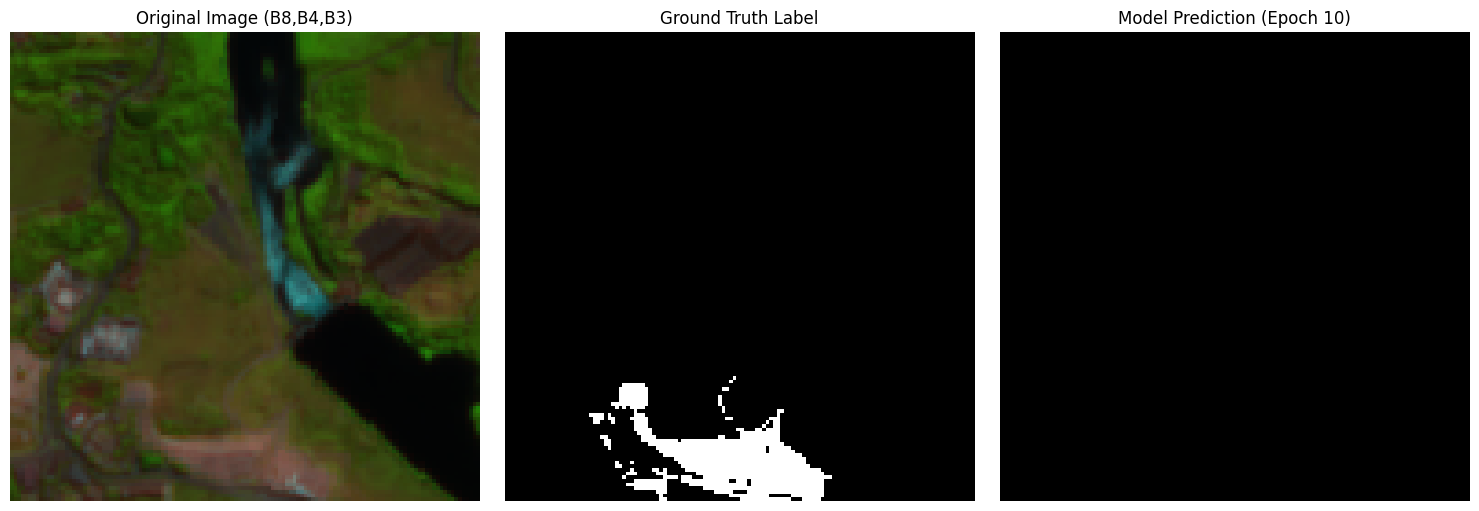

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


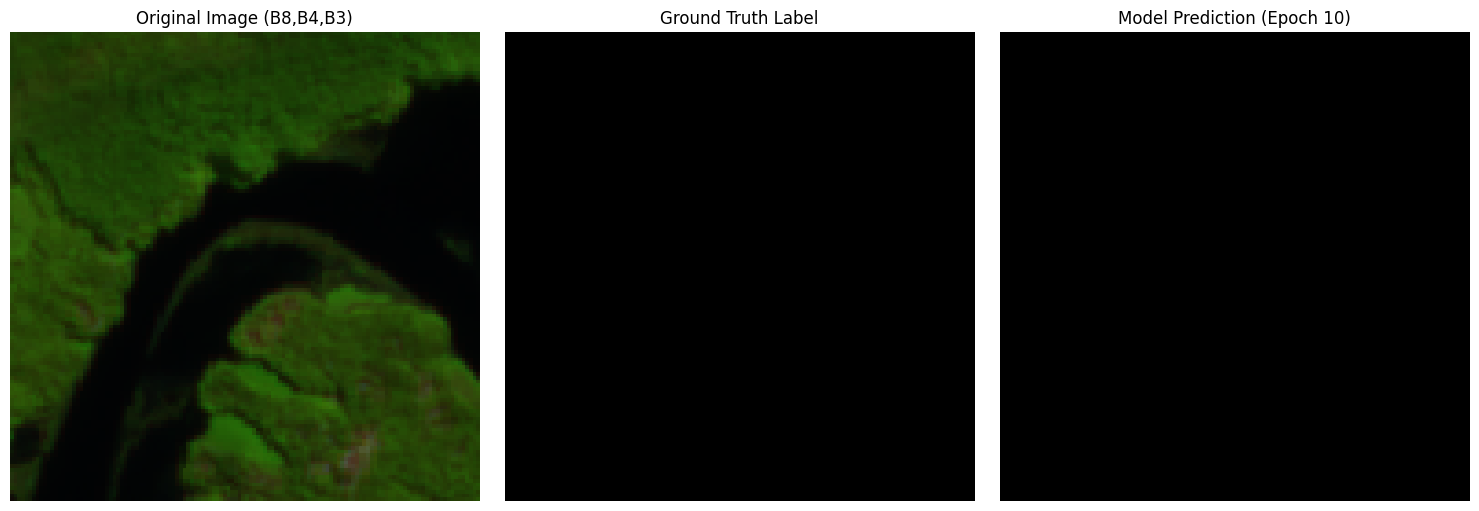

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


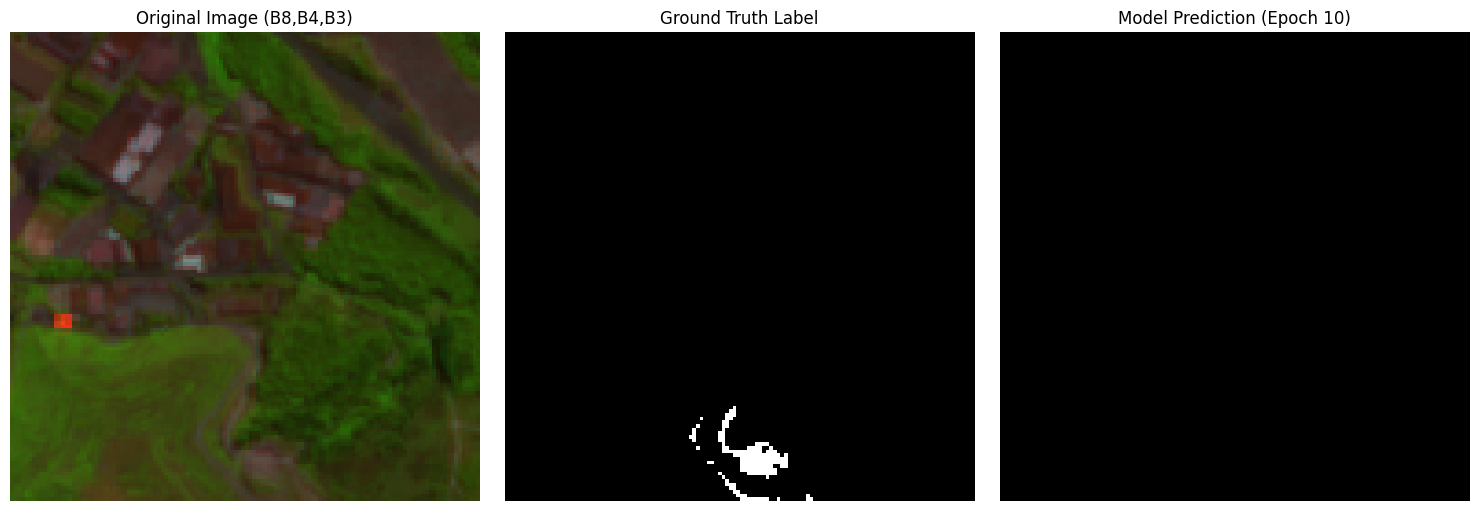

62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 291ms/step - accuracy: 0.9935 - loss: 0.0215 - mean_iou: 0.5126 - val_accuracy: 0.9964 - val_loss: 0.0116 - val_mean_iou: 0.4982
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9943 - loss: 0.0219 - mean_iou: 0.5051 - val_accuracy: 0.9964 - val_loss: 0.0115 - val_mean_iou: 0.4982
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9939 - loss: 0.0203 - mean_iou: 0.5049 - val_accuracy: 0.9964 - val_loss: 0.0115 - val_mean_iou: 0.4982
Epoch 13/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.9946 - loss: 0.0203 - mean_iou: 0.5052 - val_accuracy: 0.9964 - val_loss: 0.0121 - val_mean_iou: 0.4982
Epoch 14/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.9952 - loss: 0.0192 - mean_iou: 0.4976 - val_accuracy: 0.9964 - val_loss: 0.0118 - val_mean_iou: 0.4982
Epoch 15/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9944 - loss: 0.0215 - mean_iou: 0.4972 - val_accuracy: 0.9964 - val_loss: 0.0123 - v

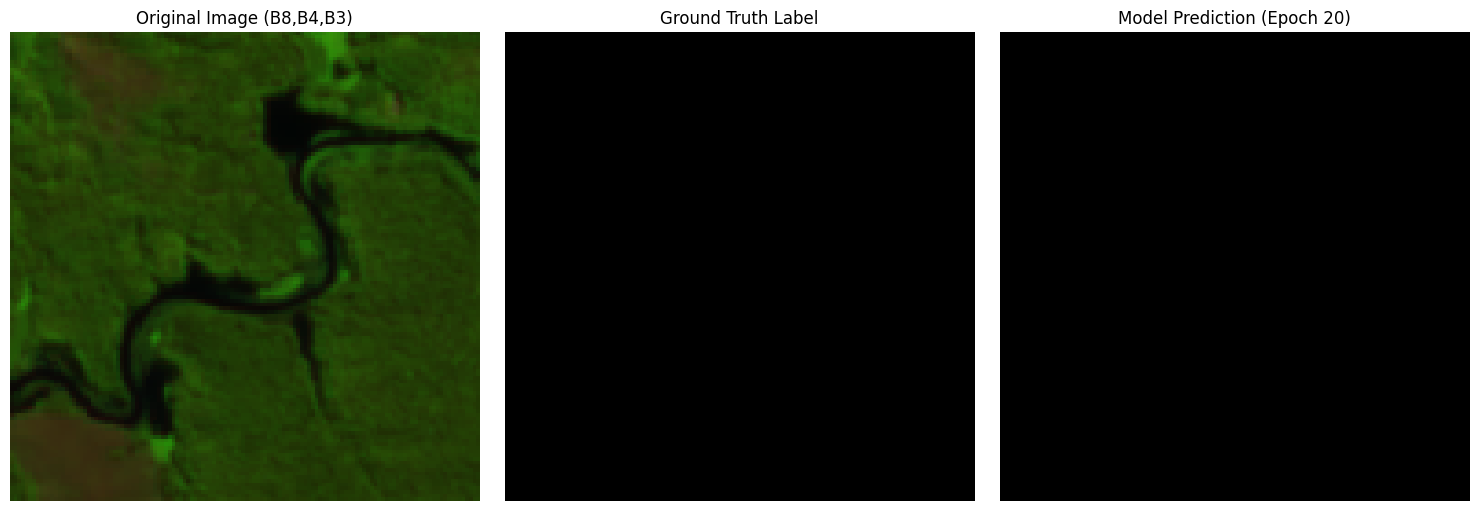

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


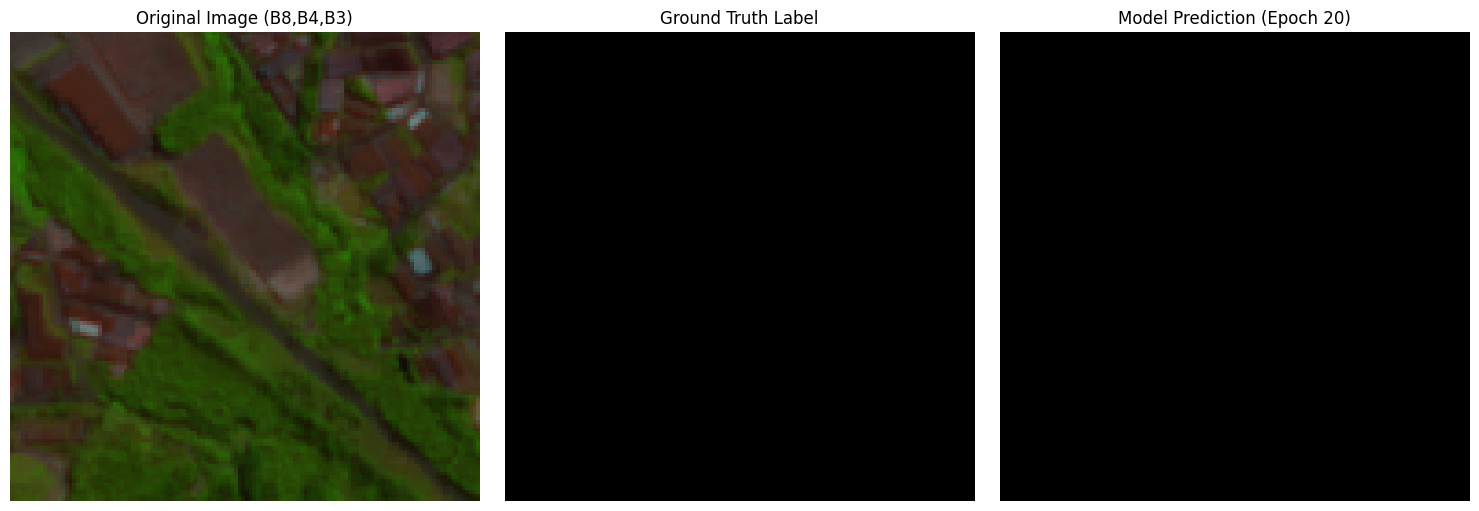

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


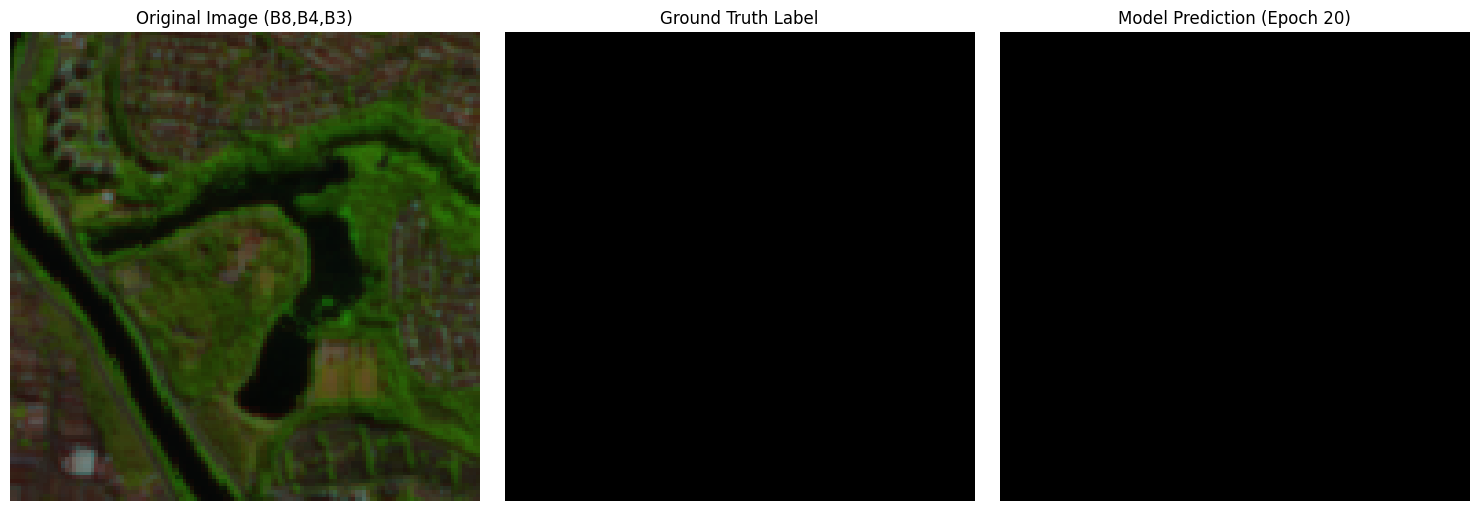

62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.9943 - loss: 0.0174 - mean_iou: 0.4972 - val_accuracy: 0.9964 - val_loss: 0.0110 - val_mean_iou: 0.4982
Epoch 21/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.9908 - loss: 0.0263 - mean_iou: 0.4954 - val_accuracy: 0.9964 - val_loss: 0.0110 - val_mean_iou: 0.4982
Epoch 22/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9900 - loss: 0.0257 - mean_iou: 0.5030 - val_accuracy: 0.9964 - val_loss: 0.0116 - val_mean_iou: 0.4982
Epoch 23/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.9921 - loss: 0.0215 - mean_iou: 0.4960 - val_accuracy: 0.9964 - val_loss: 0.0103 - val_mean_iou: 0.4982
Epoch 24/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.9895 - loss: 0.0259 - mean_iou: 0.4947 - val_accuracy: 0.9964 - val_loss: 0.0112 - val_mean_iou: 0.4982
Epoch 25/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.9919 - loss: 0.0191 - mean_iou: 0.4960 - val_accuracy: 0.9964 - val_loss: 0.0123 - v

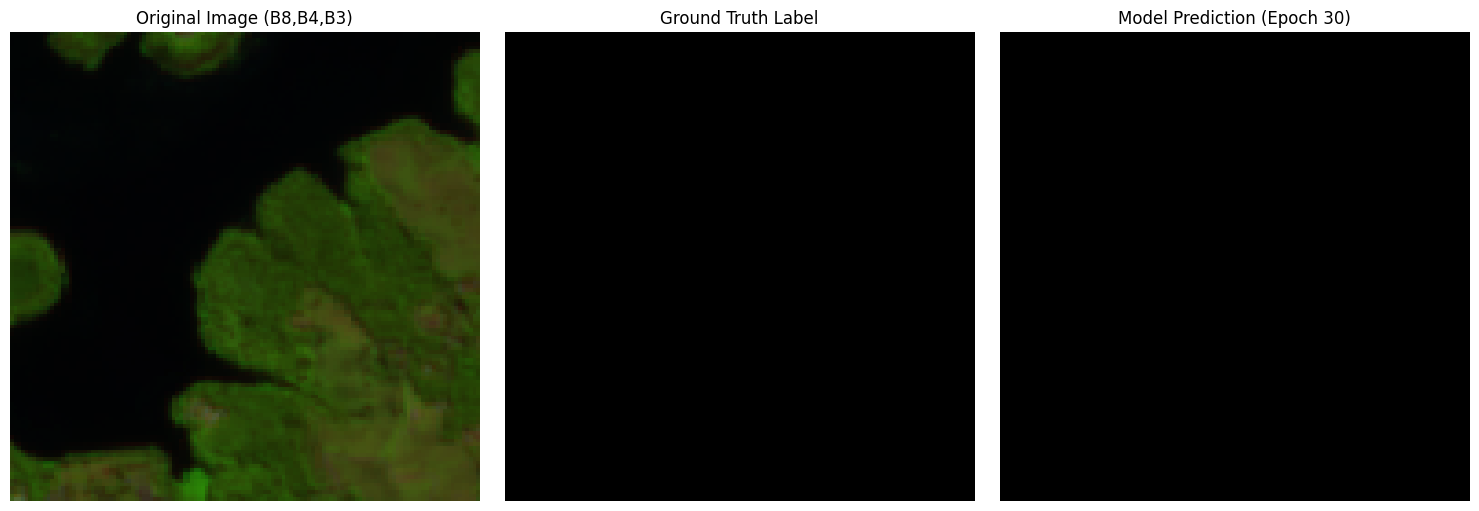

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


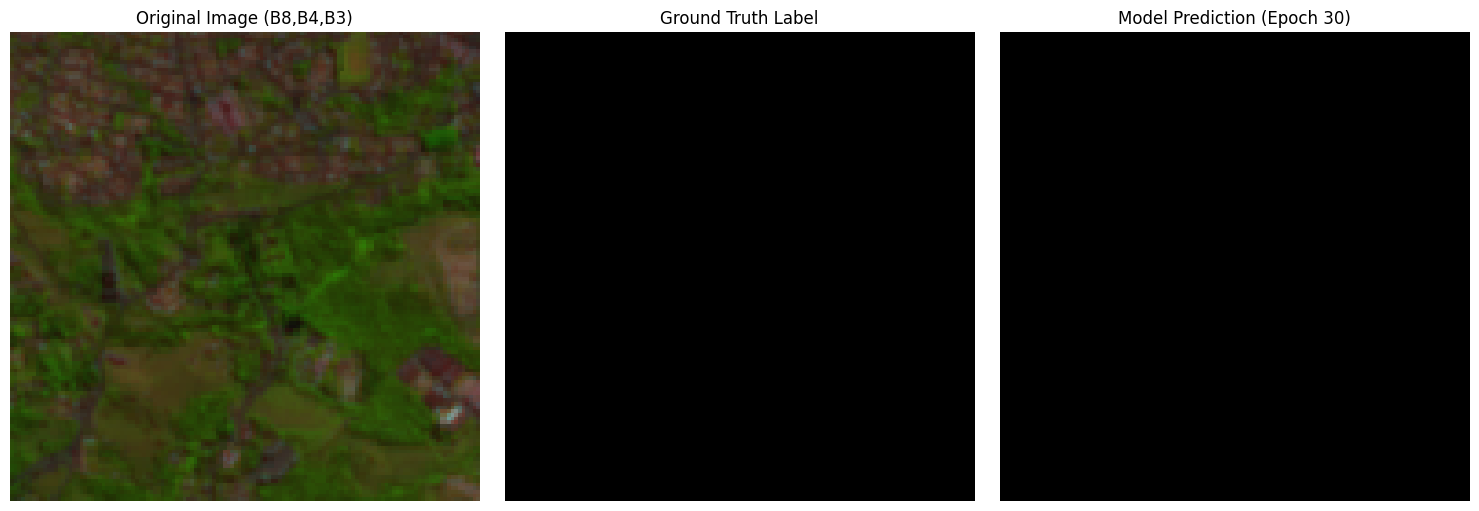

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


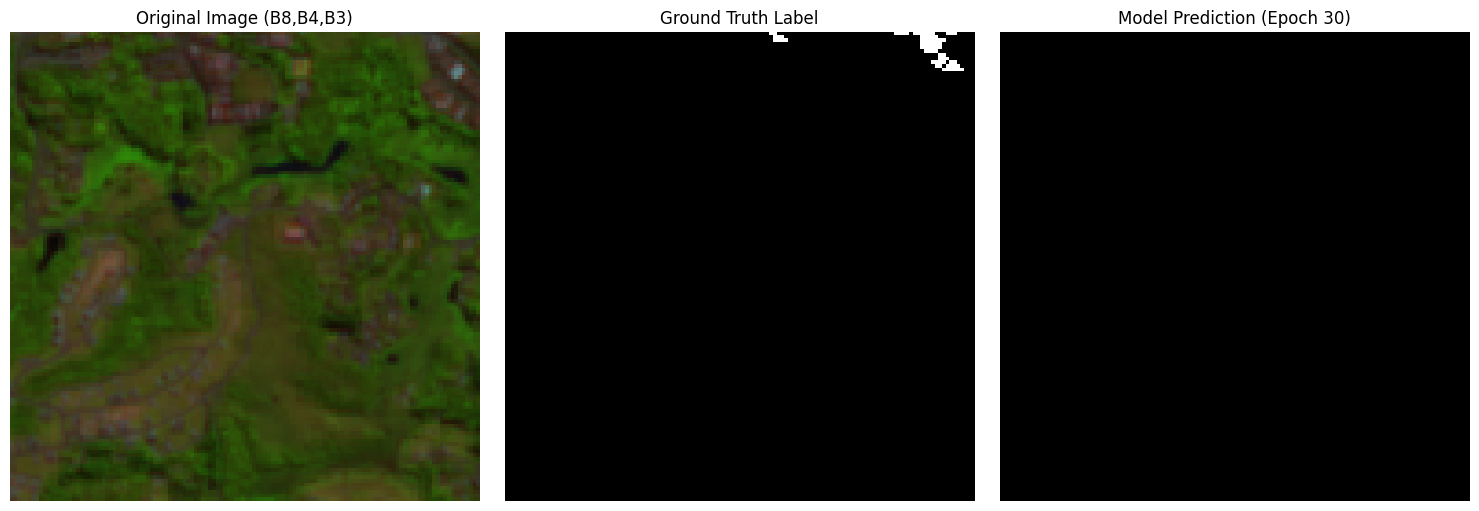

62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 292ms/step - accuracy: 0.9920 - loss: 0.0185 - mean_iou: 0.4960 - val_accuracy: 0.9965 - val_loss: 0.0096 - val_mean_iou: 0.4982
Epoch 31/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9927 - loss: 0.0162 - mean_iou: 0.5043 - val_accuracy: 0.9964 - val_loss: 0.0105 - val_mean_iou: 0.4982
Epoch 32/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9930 - loss: 0.0149 - mean_iou: 0.5203 - val_accuracy: 0.9964 - val_loss: 0.0099 - val_mean_iou: 0.4982
Epoch 33/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.9927 - loss: 0.0158 - mean_iou: 0.4964 - val_accuracy: 0.9964 - val_loss: 0.0109 - val_mean_iou: 0.4982
Epoch 34/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.9942 - loss: 0.0138 - mean_iou: 0.5130 - val_accuracy: 0.9964 - val_loss: 0.0098 - val_mean_iou: 0.4982
Epoch 35/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.9929 - loss: 0.0171 - mean_iou: 0.5282 - val_accuracy: 0.9965 - val_loss: 0.0099 - v

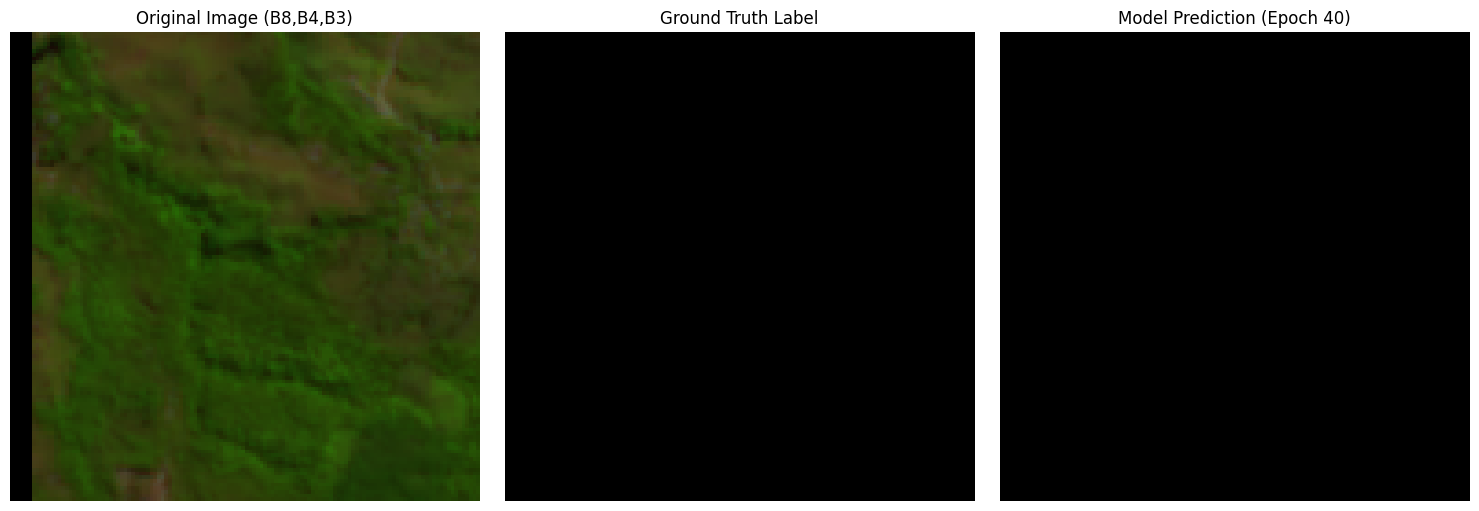

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


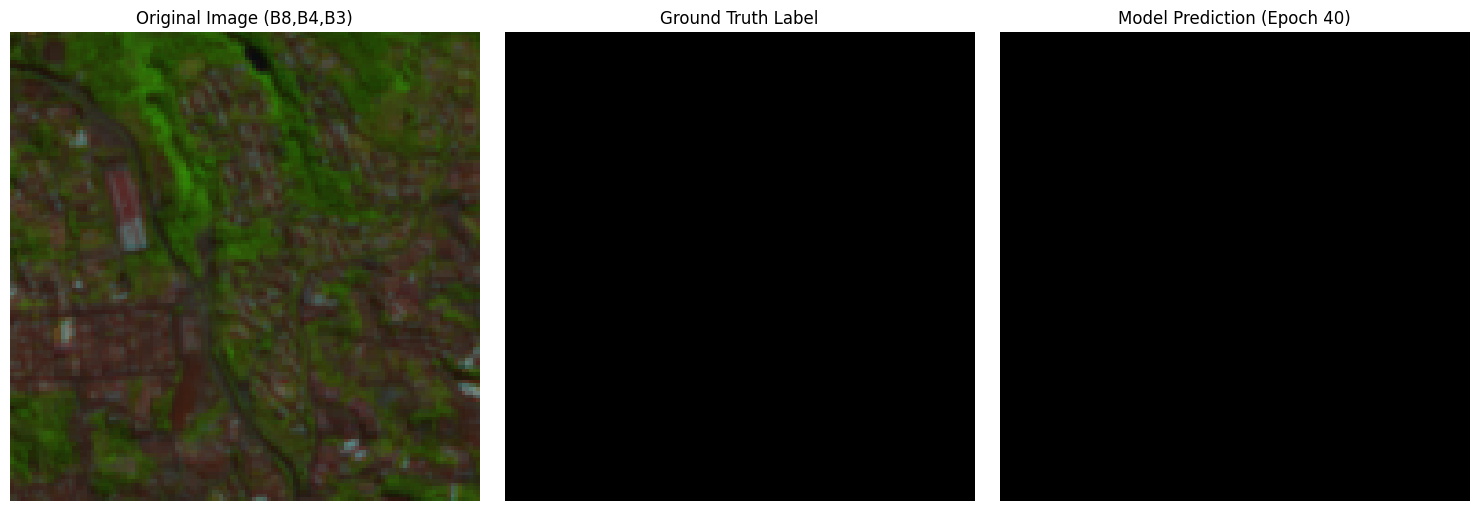

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


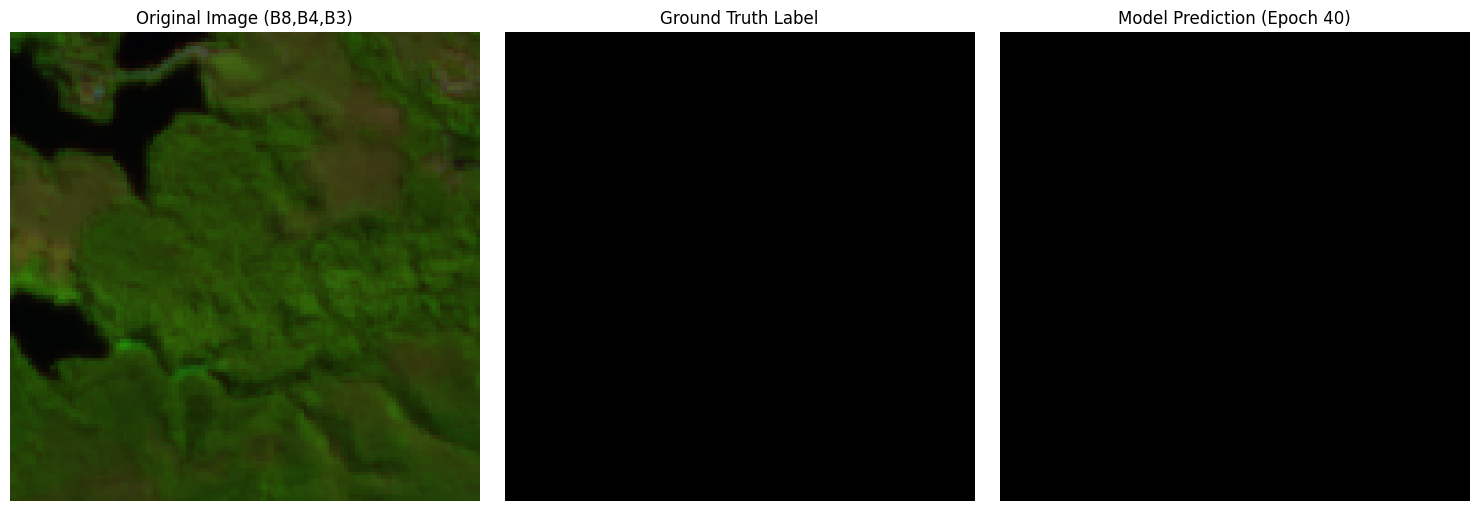

62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 299ms/step - accuracy: 0.9947 - loss: 0.0134 - mean_iou: 0.4974 - val_accuracy: 0.9964 - val_loss: 0.0105 - val_mean_iou: 0.4982
Epoch 41/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 216ms/step - accuracy: 0.9951 - loss: 0.0133 - mean_iou: 0.5055 - val_accuracy: 0.9964 - val_loss: 0.0105 - val_mean_iou: 0.4982
Epoch 42/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9941 - loss: 0.0150 - mean_iou: 0.4971 - val_accuracy: 0.9964 - val_loss: 0.0098 - val_mean_iou: 0.4982
Epoch 43/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9944 - loss: 0.0134 - mean_iou: 0.5051 - val_accuracy: 0.9964 - val_loss: 0.0100 - val_mean_iou: 0.4982
Epoch 44/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.9931 - loss: 0.0166 - mean_iou: 0.4966 - val_accuracy: 0.9964 - val_loss: 0.0096 - val_mean_iou: 0.4982
Epoch 45/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - accuracy: 0.9934 - loss: 0.0151 - mean_iou: 0.4967 - val_accuracy: 0.9964 - val_loss: 0.0110 - v

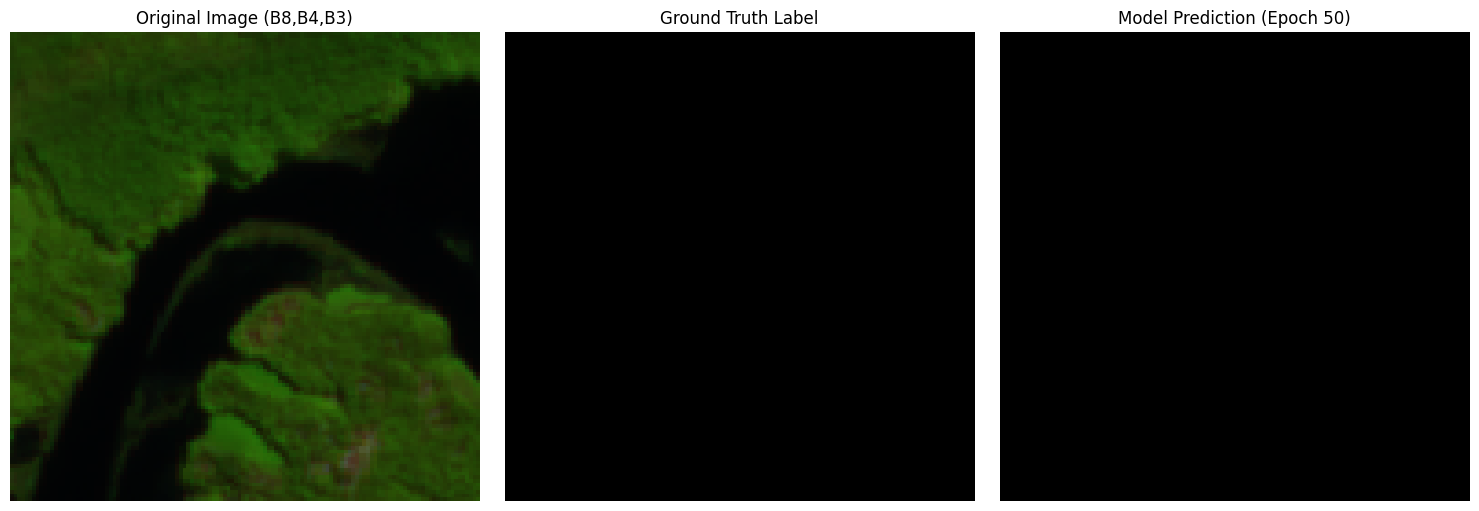

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


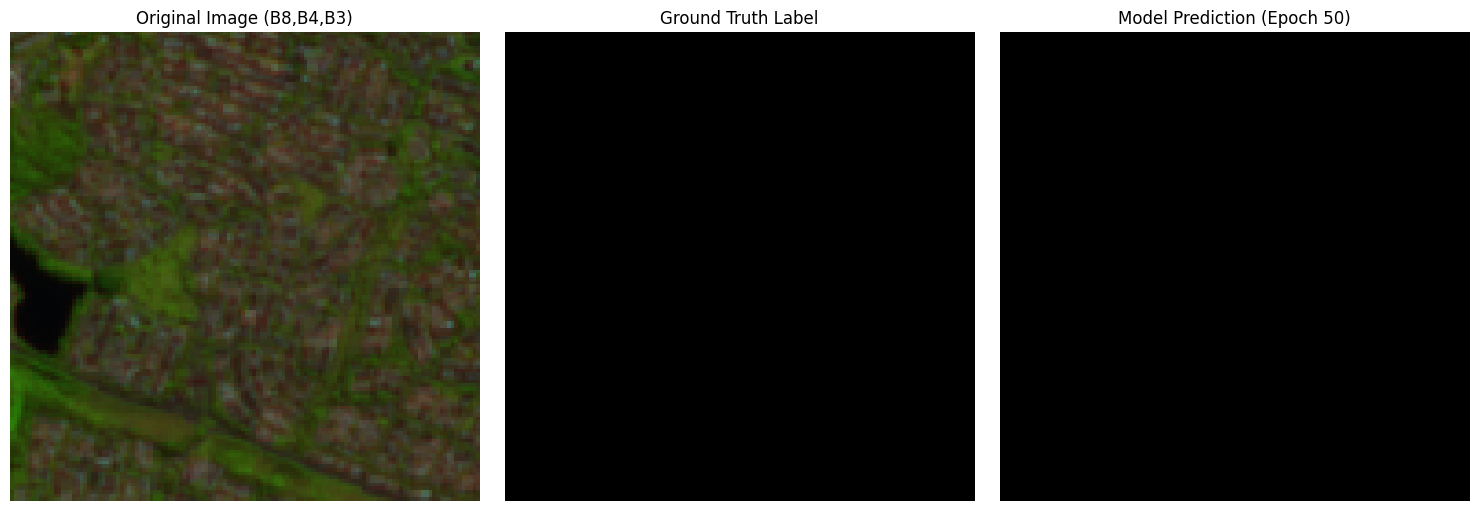

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


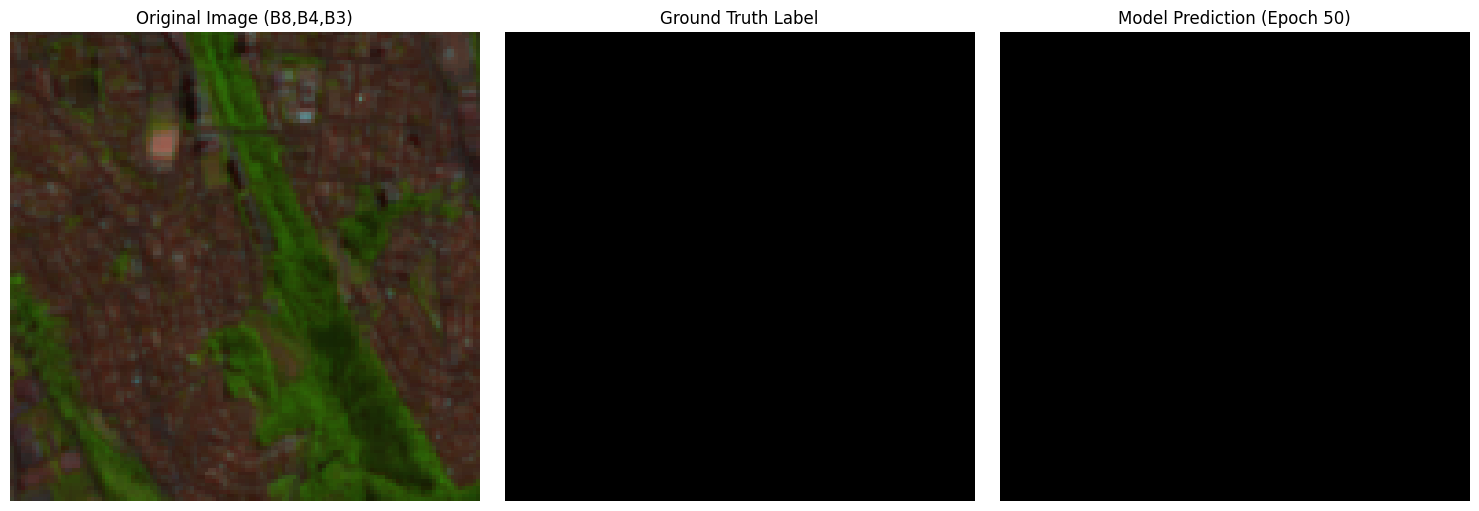

62/62 ━━━━━━━━━━━━━━━━━━━━ 18s 294ms/step - accuracy: 0.9956 - loss: 0.0123 - mean_iou: 0.5057 - val_accuracy: 0.9964 - val_loss: 0.0098 - val_mean_iou: 0.4982

Training complete!


In [329]:
PREVIEW_FREQUENCY = 10 # Display preview every N epochs
EPOCHS = 50
TRAIN_SIZE = TRAIN_SIZE # Use the counted size for steps_per_epoch

training_dataset = get_base_dataset()
validation_dataset = get_base_dataset(base_type='validation_patches')

preview_dataset = get_preview_dataset(num_batches=3) # Get 3 example batches

INITIAL_EPOCH = 0

# checkpoint_path = '//mnt/nfs/assets/dumpsites/checkpoints/final_supervised_label_v5/final_supervised_label-cp-{epoch:04d}.weights.h5' # Example path
checkpoint_path = '//mnt/nfs/assets/dumpsites/checkpoints/kmeans_validated_label_v5/kmeans_validated_label-cp-{epoch:04d}.weights.h5' # Example path

# checkpoint_path = '//mnt/nfs/assets/dumpsites/checkpoints/kmeans_validated_label-cp-{epoch:04d}.weights.h5' # Example path

# model.load_weights(f'/mnt/nfs/assets/dumpsites/checkpoints/kmeans_validated_label_v5/final_supervised_label-cp-00{INITIAL_EPOCH}.weights.h5') #uncomment if you want to join

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True, # Often better to save weights only for checkpoints
    save_best_only=False,
    save_freq=PREVIEW_FREQUENCY * int(TRAIN_SIZE / BATCH_SIZE)
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    min_delta=0.001,
    patience=15,
    mode='max',
    restore_best_weights=True
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir="/mnt/nfs/assets/dumpsites/logs/" + SUPERVISED[0] + '_v5', #+ SAMPLE_VERSION,  # or another directory
    histogram_freq=1,  # logs weights every epoch
    write_graph=True,
    write_images=True,
)

img_callback = ImagePredictionCallback(preview_dataset=preview_dataset, frequency=PREVIEW_FREQUENCY, rgb_band_indices=[4, 3, 2]) # B8, B4, B3 for RGB

# training
# print("\nStarting model training...")
# history_supervised = model.fit(
#     x=training_dataset,
#     epochs=EPOCHS,
#     initial_epoch=INITIAL_EPOCH,
#     steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE),
#     verbose=1,
#     # callbacks=[cp_callback, es_callback, tensorboard_callback, img_callback],
#     callbacks=[cp_callback, tensorboard_callback, img_callback],
#     validation_data=validation_dataset,
#     validation_steps=EVAL_SIZE,
# )

# print("\nTraining complete!")

print("\nStarting model training...")
history_unsupervised = model.fit(
    x=training_dataset,
    epochs=EPOCHS,
    initial_epoch=INITIAL_EPOCH,
    steps_per_epoch=int(TRAIN_SIZE / BATCH_SIZE),
    verbose=1,
    # callbacks=[cp_callback, es_callback, tensorboard_callback, img_callback],
    callbacks=[cp_callback, tensorboard_callback, img_callback],
    validation_data=validation_dataset,
    validation_steps=EVAL_SIZE,
)

print("\nTraining complete!")

In [330]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
history_1 = history_supervised.history
history_2 = history_unsupervised.history

# epochs = list(range(1, len(history_1['loss']) + 1))

# # Create DataFrame for loss
# loss_df = pd.DataFrame({
#     'Epoch': epochs,
#     'Train Loss': history_1['loss'],
#     'Val Loss': history_1['val_loss']
# })
# loss_df = loss_df.melt(id_vars='Epoch', var_name='Set', value_name='Loss')

# # Plot loss
# plt.figure(figsize=(8, 5))
# sns.lineplot(data=loss_df, x='Epoch', y='Loss', hue='Set', style='Set',
#              markers=True, palette=['#ff4040ff', '#3a8eedff'])
# plt.title('Loss over Epochs')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # Plot accuracy if available
# if 'accuracy' in history_1 and 'val_accuracy' in history_1:
#     acc_df = pd.DataFrame({
#         'Epoch': epochs,
#         'Train Accuracy': history_1['accuracy'],
#         'Val Accuracy': history_1['val_accuracy']
#     })
#     acc_df = acc_df.melt(id_vars='Epoch', var_name='Set', value_name='Accuracy')

#     plt.figure(figsize=(8, 5))
#     sns.lineplot(data=acc_df, x='Epoch', y='Accuracy', hue='Set', style='Set',
#                  markers=True, palette=['#ff4040ff', '#3a8eedff'])
#     plt.title('Accuracy over Epochs')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


In [331]:
import pandas as pd

# Epoch to compare (Python is 0-based, so epoch 50 is index 49)
epoch = 49

# Define the metrics you want to compare
metrics = ['loss', 'val_loss', 'accuracy', 'val_accuracy', 'mean_iou', 'val_mean_iou']

# Helper to extract value if it exists
def get_metric(history, metric, epoch):
    try:
        return history[metric][epoch]
    except (KeyError, IndexError):
        return None

# Build comparison table
data = []
for metric in metrics:
    row = {
        'Metric': metric,
        'Model 1': get_metric(history_1, metric, epoch),
        'Model 2': get_metric(history_2, metric, epoch)
    }
    data.append(row)

comparison_df = pd.DataFrame(data)
comparison_df = comparison_df.dropna(how='all', subset=['Model 1', 'Model 2'])  # drop empty rows

# Display table
print(comparison_df)


         Metric   Model 1   Model 2
0          loss  0.016508  0.015608
1      val_loss  0.012697  0.009772
2      accuracy  0.993474  0.992615
3  val_accuracy  0.995477  0.996400
4      mean_iou  0.496655  0.496307
5  val_mean_iou  0.498253  0.498200


In [318]:
import pickle
import os

# Create output directory if needed
output_dir = "/mnt/nfs/assets/dumpsites/histories/"
os.makedirs(output_dir, exist_ok=True)

# Save both histories
with open(os.path.join(output_dir, 'history_model_1.pkl'), 'wb') as f:
    pickle.dump(history_1, f)

with open(os.path.join(output_dir, 'history_model_2.pkl'), 'wb') as f:
    pickle.dump(history_2, f)

print("Histories saved.")


Histories saved.


### Prediction
After training and saving each model, we will use each one for predicting possible aggregations of waste for different areas. <br>
First, I am going to create a grid over my interest area (MRSP) of 1300 x 1300 m, where each geometry will be used to extract a 128 x 128 px patch to input into our model

In [334]:
# Load the region of interest
# roi = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1').filter(ee.Filter.eq('ADM1_NAME','Sao Paulo'));
roi = ee.FeatureCollection("users/julcansado/TFG/BASES/MUN_RMSP")
# Parameters
patch_size = 1300  # meters (e.g., 128 px * 10m/px)
overlap = 0.05      # 30% overlap
stride = patch_size * (1 - overlap) # Calculate stride in meters

target_projection_crs = 'EPSG:32723'

# --- Grid Generation Function ---
def generate_grid(region_wgs84, scale_meters, stride_meters, projection_crs):
    """
    Generates a grid of overlapping patches over a given region.
    The grid calculations are performed in a specified projected coordinate system (CRS)
    to ensure accurate handling of meter-based `scale_meters` and `stride_meters`.

    Args:
        region_wgs84 (ee.Geometry): The input region, expected to be in WGS84 (degrees).
        scale_meters (float): The desired side length of each square patch in meters.
        stride_meters (float): The step size (distance between patch origins) in meters.
                               This incorporates the overlap.
        projection_crs (str): The EPSG code of the target projected coordinate system
                              (e.g., 'EPSG:32723' for UTM Zone 23S).

    Returns:
        ee.FeatureCollection: A FeatureCollection where each feature is a grid cell
                              (ee.Geometry.Rectangle) in the specified `projection_crs`.
    """
    # 1. Reproject the input region to the target projected CRS.
    #    This ensures that all subsequent coordinate calculations are in meters.
    #    A small `maxError` (0.01 meters) is used for precision during transformation.
    region_projected = region_wgs84.transform(projection_crs, 0.01)

    # 2. Get the bounding box of the reprojected region.
    #    It's crucial to specify the `crs` argument here to get bounds in meters.
    bounds_projected = region_projected.bounds(1, projection_crs) # 1 meter error margin

    # 3. Extract the min/max coordinates (in meters) from the projected bounds.
    #    The bounds() method returns a rectangle's coordinates as a list of lists.
    coords = bounds_projected.coordinates().get(0) # Get the first vertex of the bounding box

    # Extract xmin, ymin, xmax, ymax from the bounding box coordinates.
    # For a rectangle, the first point is [xmin, ymin] and the third is [xmax, ymax].
    xmin = ee.Number(ee.List(ee.List(coords).get(0)).get(0)) # x-coord of first point
    ymin = ee.Number(ee.List(ee.List(coords).get(0)).get(1)) # y-coord of first point
    xmax = ee.Number(ee.List(ee.List(coords).get(2)).get(0)) # x-coord of third point
    ymax = ee.Number(ee.List(ee.List(coords).get(2)).get(1)) # y-coord of third point

    # 4. Generate sequences of x and y coordinates for the grid origins.
    #    We subtract `scale_meters` from `xmax`/`ymax` and add `stride_meters`
    #    to ensure the last patch starts within the region and covers it,
    #    accounting for the patch size and stride.
    x_coords = ee.List.sequence(xmin, xmax.subtract(scale_meters).add(stride_meters), stride_meters)
    y_coords = ee.List.sequence(ymin, ymax.subtract(scale_meters).add(stride_meters), stride_meters)

    # 5. Define a nested function to create a feature for each grid cell.
    def make_feature(x):
        def make_row(y):
            x0 = ee.Number(x)
            y0 = ee.Number(y)
            # Create the rectangle for the cell.
            # Specify the `projection_crs` to ensure it's created in meters.
            # `False` for `geodesic` ensures a planar rectangle, suitable for projected CRS.
            cell = ee.Geometry.Rectangle([
                x0, y0,
                x0.add(scale_meters), y0.add(scale_meters)
            ], projection_crs, False)
            return ee.Feature(cell)
        # Map `make_row` over the y_coords to create a row of cells for the current x.
        return y_coords.map(make_row)

    # 6. Map `make_feature` over the x_coords to create all rows of cells,
    #    then flatten the list of lists into a single list of features.
    cells = x_coords.map(lambda x: make_feature(x))
    return ee.FeatureCollection(cells.flatten())

# --- Generate the Grid ---
print(f"Generating grid with patch size: {patch_size}m, overlap: {overlap*100}%, stride: {stride}m")
print(f"Region will be reprojected to: {target_projection_crs}")
grid_fc = generate_grid(roi.geometry(), patch_size, stride, target_projection_crs)
print(f"Grid generated. Number of patches: {grid_fc.size().getInfo()}")


task = ee.batch.Export.table.toDrive(collection=grid_fc,
                                     description='grid_patches_export_RMSP',
                                     folder='EarthEngine_Exports_2', # Optional: specify a folder in your Drive
                                     fileNamePrefix='grid_patches_RMSP',
                                     fileFormat='SHP') # Or 'CSV', 'SHP', 'KML'

# Start the export task
# task.start()

print("Export task started. Check your Earth Engine Tasks tab (https://code.earthengine.google.com/tasks) for progress and your Google Drive.")


Generating grid with patch size: 1300m, overlap: 5.0%, stride: 1235.0m
Region will be reprojected to: EPSG:32723
Grid generated. Number of patches: 14750
Export task started. Check your Earth Engine Tasks tab (https://code.earthengine.google.com/tasks) for progress and your Google Drive.


There were 14750 grids total, but I opened it in Earth Engine and only selected those who overlap with MRSP - the grid was created over the region's bounds, so we have many extra geometries we don't need to predict.
In the next cell, we start the exporting of 7171 geotiff patches to predict (they'll be going to my Google Drive).

PS.: This is approximately 5GB of data.

In [395]:
# --- 1. Prepare Image ---
# Load your GEE mosaic asset
gee_mosaic = ee.Image('projects/dumpsites-id/assets/mosaic_v4')

band_names = BANDS 

input_image = gee_mosaic.select(band_names).toFloat()
# normalized_image = input_image.divide(10000.0) # Example: assuming 16-bit data scaled to 0-1

# --- 2. Load Your Grid FeatureCollection ---
# This is the asset ID of your grid
grid_fc = ee.FeatureCollection('projects/dumpsites-id/assets/grid_RMSP_v2_filter')

# Define the Google Drive folder for the output files
drive_folder = 'tiles_to_predict_RMSP' # This folder will be created in your Google Drive root

# --- 3. Iterate and Launch Export Tasks ---
# Get the grid as a client-side list to iterate over
grid_list = grid_fc.toList(grid_fc.size())
number_of_features = grid_list.size().getInfo()

# number_of_features = 10
print(f"Found {number_of_features} grid cells to export.")

# # WARNING: This loop will launch a separate export task for EACH feature in your grid.
# # Check your GEE Tasks tab to monitor them.
for i in range(number_of_features):
    feature = ee.Feature(grid_list.get(i))
    geom = feature.geometry()
    tile = input_image.clip(geom)

    file_name = f'image_tile_{i:03d}'

    task = ee.batch.Export.image.toDrive(
        image=tile,
        description=file_name,
        folder=drive_folder,
        fileNamePrefix=file_name,
        region=geom.bounds().getInfo()['coordinates'],
        scale=10,
        maxPixels=1e13,
        fileFormat='GeoTIFF',
        formatOptions={'cloudOptimized': True}
    )

    task.start()
    print(f'Started export: {file_name}')


Found 7171 grid cells to export.
Started export: image_tile_000
Started export: image_tile_001
Started export: image_tile_002
Started export: image_tile_003
Started export: image_tile_004
Started export: image_tile_005
Started export: image_tile_006
Started export: image_tile_007
Started export: image_tile_008
Started export: image_tile_009
Started export: image_tile_010
Started export: image_tile_011
Started export: image_tile_012
Started export: image_tile_013
Started export: image_tile_014
Started export: image_tile_015
Started export: image_tile_016
Started export: image_tile_017
Started export: image_tile_018
Started export: image_tile_019
Started export: image_tile_020
Started export: image_tile_021
Started export: image_tile_022
Started export: image_tile_023
Started export: image_tile_024
Started export: image_tile_025
Started export: image_tile_026
Started export: image_tile_027
Started export: image_tile_028
Started export: image_tile_029
Started export: image_tile_030
Starte

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



I used slightly bigger geometries than needed - 1300 x 1300 meters rather than 1280 x 1280, so we have to crop each patch before inputing it into the model.

In [378]:
import tensorflow as tf
import numpy as np
import rasterio

def load_and_preprocess_tile(filepath, num_bands, target_size=128):
    with rasterio.open(filepath) as src:
        img = src.read()  # shape: (bands, H, W)

    img = np.transpose(img, (1, 2, 0))  # → (H, W, bands)
    img = img.astype(np.float32) / 10000.0

    # Convert to tensor
    img = tf.convert_to_tensor(img)

    # Center crop or pad to exactly 128×128
    img = tf.image.resize_with_crop_or_pad(img, target_size, target_size)

    return tf.expand_dims(img, axis=0)  # shape: (1, 128, 128, 10)


In [379]:
import os
from glob import glob
import rasterio
import numpy as np
from rasterio.transform import from_origin

def predict_tile_and_save(input_path, output_path, model, num_bands=10):
    # Load and preprocess
    tensor = load_and_preprocess_tile(input_path, num_bands=num_bands)
    prediction = model.predict(tensor)

    # Remove batch dim and squeeze final axis (e.g., shape [1, 128, 128, 1] → [128, 128])
    predicted_mask = np.squeeze(prediction, axis=(0, -1))

    # Save using original tile metadata
    with rasterio.open(input_path) as src:
        profile = src.profile
        profile.update({
            'count': 1,
            'dtype': 'float32',
            'compress': 'lzw'
        })
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(predicted_mask.astype(np.float32), 1)


Set input and output paths, and which model to use for the prediction.

In [393]:
input_dir = "/mnt/nfs/assets/dumpsites/to_predict/"
# output_dir = "/mnt/nfs/assets/dumpsites/predictions/kmeans_validated_label_v5/"
output_dir = "/mnt/nfs/assets/dumpsites/predictions/final_supervised_label_v5/"
os.makedirs(output_dir, exist_ok=True)

# model.load_weights('/mnt/nfs/assets/dumpsites/checkpoints/kmeans_validated_label_v5/kmeans_validated_label-cp-0050.weights.h5') #uncomment if you want to join
model.load_weights('/mnt/nfs/assets/dumpsites/checkpoints/final_supervised_label_v5/final_supervised_label-cp-0050.weights.h5') #uncomment if you want to join

tile_paths = sorted(glob(os.path.join(input_dir, "image_tile_*.tif")))

for tile_path in tile_paths:
    tile_name = os.path.basename(tile_path).replace("image_tile_", "pred_tile_")
    output_path = os.path.join(output_dir, tile_name)
    predict_tile_and_save(tile_path, output_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

Join every predicted patch into a single image.

In [394]:
from rasterio.merge import merge

predicted_tiles = sorted(glob(os.path.join(output_dir, "pred_tile_*.tif")))

# Read all tiles
srcs = [rasterio.open(path) for path in predicted_tiles]

# Merge with rasterio
merged_array, merged_transform = merge(srcs)

# Use metadata from the first tile
out_meta = srcs[0].meta.copy()
out_meta.update({
    "height": merged_array.shape[1],
    "width": merged_array.shape[2],
    "transform": merged_transform,
    "count": 1
})

# Save merged prediction
merged_output_path = os.path.join(output_dir, "merged_prediction_rf.tif")
with rasterio.open(merged_output_path, "w", **out_meta) as dest:
    dest.write(merged_array[0], 1)


The end! Go look at the final result!!